# Data Exploration of Physical Therapy Dataset

## Imports + Data

In [58]:
import os
import sys

# Add parent folder to sys.path
sys.path.append(os.path.abspath(".."))
from functools import reduce

import math
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from helpers.load_data import load_and_merge_sensors
from helpers.filtering import preprocess_sensor_data
from helpers.segment import segment_series

import seglearn as seg
import tensorflow as tf
import sklearn




In [59]:
# Download latest version
path = kagglehub.dataset_download("rabieelkharoua/physical-therapy-exercises-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/hammy/.cache/kagglehub/datasets/rabieelkharoua/physical-therapy-exercises-dataset/versions/1


Collecting metadata for template times and subject/exercise/sensor information to use for later

## Data Loading

In [60]:
from helpers.load_data import load_data
df, template_times = load_data(path)

In [61]:
times_sorted = template_times.sort_values(by=['subject', 'exercise']).reset_index().drop('index', axis=1)
times_sorted.head()

,subject,exercise,file_name,path
0,s1,e1,template_times.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
1,s1,e2,template_times.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
2,s1,e3,template_times.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
3,s1,e4,template_times.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
4,s1,e5,template_times.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...


In [62]:
templates = df[df['file_name'] == 'template_session.txt'].reset_index()
tests = df[df['file_name'] != 'template_session.txt'].reset_index()
templates

,index,subject,exercise,sensor,file_name,path
0,0,s1,e1,u1,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
1,2,s1,e1,u2,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
2,4,s1,e1,u3,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
3,6,s1,e1,u4,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
4,8,s1,e1,u5,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
...,...,...,...,...,...,...
195,390,s5,e8,u1,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
196,392,s5,e8,u2,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
197,394,s5,e8,u3,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
198,396,s5,e8,u4,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...


In [63]:
tests

,index,subject,exercise,sensor,file_name,path
0,1,s1,e1,u1,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
1,3,s1,e1,u2,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
2,5,s1,e1,u3,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
3,7,s1,e1,u4,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
4,9,s1,e1,u5,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
...,...,...,...,...,...,...
195,391,s5,e8,u1,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
196,393,s5,e8,u2,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
197,395,s5,e8,u3,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
198,397,s5,e8,u4,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...


## Data Exploration

### Missing Values

## Data Preprocessing

### Filtering

### Activity Detection

In [64]:
import numpy as np

def detect_activity(df, motion_threshold=1, min_active=5, min_idle=1,
                        fs=25, cutoff=5, use_acc=False):
    """
    Detect rep start and end based on motion magnitude.
    
    Returns df with:
        - 'rep_start', 'rep_end' (1 if this sample is start/end of a rep)
        - optionally filtered gyro: 'gx_f', 'gy_f', 'gz_f'
        - optionally filtered accelerometer: 'ax_f', 'ay_f', 'az_f'
    """
    
    df = df.copy()
    num_samples = len(df)
    
    gyr_mag_list = []
    acc_mag_list = [] if use_acc else None
    
    # --- Filter signals and compute magnitudes ---
    for i in range(1,6):
        gx = lowpass(df[f'gyr_x_u{i}'].values, fs, cutoff)
        gy = lowpass(df[f'gyr_y_u{i}'].values, fs, cutoff)
        gz = lowpass(df[f'gyr_z_u{i}'].values, fs, cutoff)
        
        df[f'gx_f_u{i}'] = gx
        df[f'gy_f_u{i}'] = gy
        df[f'gz_f_u{i}'] = gz
        
        gyr_mag_list.append(np.sqrt(gx**2 + gy**2 + gz**2))
        df[f'gyr_mag_u{i}'] = np.sqrt(gx**2 + gy**2 + gz**2)
        
        if use_acc:
            ax = lowpass(df[f'acc_x_u{i}'].values, fs, cutoff)
            ay = lowpass(df[f'acc_y_u{i}'].values, fs, cutoff)
            az = lowpass(df[f'acc_z_u{i}'].values, fs, cutoff)
            df[f'ax_f_u{i}'] = ax
            df[f'ay_f_u{i}'] = ay
            df[f'az_f_u{i}'] = az
            acc_mag_list.append(np.sqrt(ax**2 + ay**2 + az**2))
    
    # --- Combine magnitudes across sensors ---
    combined_mag = np.max(np.stack(gyr_mag_list), axis=0)
    if use_acc:
        combined_mag = np.maximum(combined_mag, np.max(np.stack(acc_mag_list), axis=0))
    
    # --- Threshold magnitude to detect motion ---
    active = (combined_mag > motion_threshold).astype(int)
    
    # --- Merge short bursts/gaps ---
    def merge_segments(active, min_active, min_idle):
        active = active.copy()
        # fill single gaps
        for i in range(1, len(active)-1):
            if active[i]==0 and active[i-1]==1 and active[i+1]==1:
                active[i] = 1
        # remove short active bursts
        starts = np.where((active[1:] == 1) & (active[:-1]==0))[0]+1
        for s in starts:
            e = s
            while e < len(active) and active[e]==1:
                e += 1
            if e - s < min_active:
                active[s:e] = 0
        # merge short idle gaps
        idle_starts = np.where((active[1:] == 0) & (active[:-1]!=0))[0]+1
        for s in idle_starts:
            e = s
            while e < len(active) and active[e]==0:
                e += 1
            if e - s < min_idle:
                active[s:e] = 1
        return active
    
    active = merge_segments(active, min_active, min_idle)
    
    # --- Detect segment starts and ends ---
    rep_start = np.zeros(num_samples, dtype=int)
    rep_end = np.zeros(num_samples, dtype=int)
    
    starts = np.where((active[1:] == 1) & (active[:-1]==0))[0]+1
    for s in starts:
        e = s
        while e < num_samples and active[e]==1:
            e += 1
        rep_start[s] = 1
        rep_end[e-1] = 1
    
    df['rep_start'] = rep_start
    df['rep_end'] = rep_end
    
    return df


### Filtering

In [65]:
filtered = []

for subject in templates['subject'].unique():
    for exercise in templates['exercise'].unique():
        df = load_and_merge_sensors(templates, subject, exercise)
        filtered.append(preprocess_sensor_data(df))
        
filtered[0]

,acc_x_u1,acc_y_u1,acc_z_u1,gyr_x_u1,gyr_y_u1,gyr_z_u1,mag_x_u1,mag_y_u1,mag_z_u1,acc_x_u2,...,acc_y_u5,acc_z_u5,gyr_x_u5,gyr_y_u5,gyr_z_u5,mag_x_u5,mag_y_u5,mag_z_u5,subject,exercise
time index,,,,,,,,,,,,,,,,,,,,,
1,-0.005925,0.001599,0.002504,0.001238,-0.000621,-0.003074,-0.000013,-0.000011,0.000075,-0.087906,...,-0.000345,-0.003095,0.000040,-0.000508,0.000819,0.000097,-0.000116,0.000084,s1,e1
2,0.016530,-0.018737,-0.004122,0.013005,-0.003078,-0.009713,0.000460,0.000185,0.000623,-0.104909,...,-0.004882,0.000916,0.000397,0.007871,-0.010165,-0.000464,0.001499,0.000003,s1,e1
3,0.028612,-0.021703,-0.010928,0.017947,-0.005115,-0.014210,0.000894,0.000174,0.001079,-0.106260,...,-0.004401,0.006685,-0.000868,0.011156,-0.015763,-0.000795,0.002409,-0.000017,s1,e1
4,0.034016,-0.007648,-0.018831,0.013622,-0.006014,-0.014018,0.001423,-0.000103,0.001460,-0.083960,...,0.003160,0.020940,-0.004410,0.009418,-0.015215,-0.000845,0.002741,-0.000201,s1,e1
5,0.021666,0.024540,-0.026685,0.009246,-0.007639,-0.016692,0.001554,-0.000387,0.001582,-0.070038,...,0.008574,0.017838,-0.007933,0.002345,-0.013137,-0.000772,0.002062,0.000270,s1,e1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183,-0.010480,-0.017195,0.040267,0.002228,-0.006924,0.000418,-0.000016,0.001758,-0.000504,-0.024144,...,-0.011802,0.010012,-0.003394,-0.004975,-0.003719,-0.001245,0.001041,-0.000712,s1,e1
2184,-0.007619,-0.009819,0.017226,0.001803,-0.003866,-0.000777,-0.000400,0.001935,-0.000554,-0.041342,...,-0.011025,0.001695,-0.000322,-0.000051,-0.007293,-0.001166,0.001196,-0.000424,s1,e1
2185,-0.003007,-0.007274,0.005069,-0.000060,-0.002563,-0.005146,-0.001094,0.000822,-0.000144,-0.036070,...,-0.004414,-0.002978,-0.000312,0.005309,-0.006476,-0.000964,0.001360,-0.000681,s1,e1


In [66]:
filtered_df = pd.concat(filtered)
filtered_df.shape

(55325, 47)

### Segmenting

In [67]:
sensor_cols = [col for col in filtered_df.columns if any(sensor in col for sensor in ['acc_', 'gyr_', 'mag_'])]

X_segments_list = []
y_segments_list = []

label_map = {
    'e1': 1,
    'e2': 2,
    'e3': 3,
    'e4': 4,
    'e5': 5,
    'e6': 6,
    'e7': 7,
    'e8': 8
}

filtered_df['exercise'] = filtered_df['exercise'].map(label_map)

X_segments_list = []
y_segments_list = []
subject_windows_list = []

for (subject, exercise), group in filtered_df.groupby(['subject', 'exercise']):
    X = group[sensor_cols].values
    y_labels = group['exercise'].values  # numeric labels now

    X_windows, y_windows = segment_series(X, window_size=50, stride=25, y_labels=y_labels)
    X_segments_list.append(X_windows)
    y_segments_list.append(y_windows)
    
    # Keep track of subject for each window
    subject_windows_list.append(np.array([subject]*len(X_windows)))

# Combine all
X_segments = np.concatenate(X_segments_list, axis=0)
y_segments = np.concatenate(y_segments_list, axis=0)
subject_windows = np.concatenate(subject_windows_list, axis=0)  # NEW



### Normalization

In [68]:
from sklearn.preprocessing import StandardScaler

num_windows, window_size, num_sensors = X_segments.shape
X_flat = X_segments.reshape(num_windows, window_size * num_sensors)
X_scaled = StandardScaler().fit_transform(X_flat)
X_windows_scaled = X_scaled.reshape(num_windows, window_size, num_sensors)

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Flatten, Dense, Dropout, BatchNormalization

def build_model(window_size, num_sensors, num_classes, use_lstm=False):
    """
    Builds a Keras model for multivariate time-series sensor data.

    Parameters:
    - window_size: int, number of timesteps per window
    - num_sensors: int, number of sensor channels
    - num_classes: int, number of output classes
    - use_lstm: bool, if True adds an LSTM layer after CNN

    Returns:
    - Keras compiled model
    """
    model = Sequential()
    
    # First CNN layer
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, num_sensors)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    
    # Second CNN layer
    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    
    if use_lstm:
        model.add(LSTM(64, return_sequences=False))
    else:
        model.add(Flatten())
    
    # Dense layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model


In [70]:
from tensorflow.keras.utils import to_categorical
import numpy as np

subjects = np.unique(filtered_df['subject'].values)
num_classes = len(label_map)  # 8

loso_accuracies = []

for test_subject in np.unique(subject_windows):
    train_idx = subject_windows != test_subject
    test_idx = subject_windows == test_subject

    X_train = X_segments[train_idx]
    y_train = y_segments[train_idx]
    X_test = X_segments[test_idx]
    y_test = y_segments[test_idx]

    # One-hot encode labels
    y_train_onehot = to_categorical(y_train - 1, num_classes=num_classes)
    y_test_onehot = to_categorical(y_test - 1, num_classes=num_classes)

    # Build your model
    model = build_model(window_size=X_train.shape[1], num_sensors=X_train.shape[2], num_classes=num_classes)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train
    model.fit(X_train, y_train_onehot, epochs=20, batch_size=32, verbose=0)

    # Evaluate
    loss, acc = model.evaluate(X_test, y_test_onehot, verbose=0)
    print(f"Test subject {test_subject}: accuracy = {acc:.3f}")
    loso_accuracies.append(acc)

print(f"Average LOSO accuracy: {np.mean(loso_accuracies):.3f}")


/Users/hammy/Projects/CS156/Project/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test subject s1: accuracy = 0.616
Test subject s2: accuracy = 0.898
Test subject s3: accuracy = 0.904
Test subject s4: accuracy = 0.894
Test subject s5: accuracy = 0.952
Average LOSO accuracy: 0.853


In [71]:
def collect_template_times(template_times, subject, exercise):
    files = template_times[
        (template_times['subject'] == subject) & 
        (template_times['exercise'] == exercise)
    ]['path'].tolist()
    dfs = [pd.read_csv(f, sep=";") for f in files]
    return dfs[0]
        

In [72]:
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean


def dtw_label_transfer(template_X, template_y, target_X):
    """
    Transfer labels from a labeled template rep to an unlabeled rep using DTW.

    Parameters:
        template_X : array (T1, F)
            Labeled rep sensor data (e.g., acc/gyro/mag)
        template_y : array (T1,)
            Labels for each timestep of the template rep
        target_X : array (T2, F)
            Unlabeled rep sensor data

    Returns:
        auto_labels : array (T2,)
            Labels aligned to the target rep
    """

    # Ensure shape is (timesteps, features)
    template_X = np.asarray(template_X)
    template_y = np.asarray(template_y)
    target_X = np.asarray(target_X)

    # Perform DTW alignment between reps
    _, path = fastdtw(target_X, template_X, dist=euclidean)

    # Label the target rep using the DTW mapping
    auto_labels = np.zeros(len(target_X), dtype=template_y.dtype)

    for idx_target, idx_temp in path:
        auto_labels[idx_target] = template_y[idx_temp]

    return auto_labels

In [73]:
def process_subject_exercise(sensor_files, subject, exercise, intervals=None,
                             motion_threshold=0.2, min_active=5, min_idle=10,
                             min_burst=1, fs=25, cutoff=5, use_acc=False):
    """
    Load & merge all units for a subject/exercise, detect rep starts/ends,
    optionally DTW-label using template intervals.

    Parameters
    ----------
    sensor_files : pd.DataFrame
        DataFrame with columns ['subject', 'exercise', 'path']
    subject : str
        Subject ID
    exercise : str
        Exercise ID
    intervals : dict or None
        If dict: {(subject, exercise): [(start, end, label), ...]}
        If None: no DTW labeling; function just merges units.
    motion_threshold, min_active, min_idle, min_burst, fs, cutoff, use_acc : parameters
        Passed to `detect_activity_with_bursts`.

    Returns
    -------
    full_df : pd.DataFrame
        Merged sensor data with rep start/end columns and optional DTW labels.
    """

    # -------------------------
    # 1. Load & merge all units for this subject/exercise
    # -------------------------
    merged_df = load_and_merge_sensors(sensor_files, subject, exercise)

    # -------------------------
    # 2. Detect rep start/end
    # -------------------------
    merged_df = detect_activity(
        merged_df,
        motion_threshold=motion_threshold,
        min_active=min_active,
        min_idle=min_idle,
        fs=fs,
        cutoff=cutoff,
        use_acc=use_acc
    )

    # -------------------------
    # 3. DTW labeling (if intervals provided)
    # -------------------------
    if intervals is not None:
        if (subject, exercise) not in intervals:
            raise ValueError(f"No template intervals defined for ({subject}, {exercise})")

        rep_intervals = intervals[(subject, exercise)]
        template_rep_index = 0  # assume first rep is labeled
        template_df = merged_df.iloc[:len(merged_df)]  # use entire merged_df as template

        # Build template labels
        T = len(template_df)
        template_y = np.zeros(T, dtype=int)
        for start, end, label in rep_intervals:
            start = max(0, start)
            end = min(T, end)
            template_y[start:end] = label

        # Which columns to use for DTW
        sensor_cols = [c for c in template_df.columns if c.startswith(("acc", "gyr", "mag"))]
        template_X = template_df[sensor_cols].to_numpy()

        # Apply DTW labeling
        full_df = merged_df.copy()
        full_df["label"] = dtw_label_transfer(template_X, template_y, full_df[sensor_cols].to_numpy())

    else:
        # -------------------------
        # No intervals → just return merged_df with rep start/end
        # -------------------------
        full_df = merged_df.copy()
        full_df["label"] = full_df["rep_start"] if "rep_start" in full_df.columns else 0

    return full_df


In [74]:
import pandas as pd

def build_template_intervals(times_sorted_df):
    """
    Converts all your times CSVs into a dictionary:
        (subject, exercise) -> list of (start, end, label) tuples
    """
    template_intervals = {}

    for _, row in times_sorted_df.iterrows():
        subject  = row['subject']
        exercise = row['exercise']

        # read CSV
        df = pd.read_csv(row['path'], sep=';')

        # convert to list of tuples
        intervals = [
            (int(r['start']), int(r['end']), int(r['execution type']))
            for _, r in df.iterrows()
        ]

        # assign to dictionary
        template_intervals[(subject, exercise)] = intervals

    return template_intervals

def label_all_reps(sensor_files, times_sorted_df):
    """
    Automatically DTW-label all reps using one template per (subject, exercise),
    and keep metadata columns.
    """
    # Build template intervals
    template_intervals = build_template_intervals(times_sorted_df)

    # Collect all labeled dfs
    all_subjects_dfs = []

    for (subject, exercise) in template_intervals.keys():
        # Get merged and labeled DataFrame
        df_labeled = process_subject_exercise(
            sensor_files=sensor_files,
            subject=subject,
            exercise=exercise,
            intervals=template_intervals
        )

        # Add metadata columns
        df_labeled['subject'] = subject
        df_labeled['exercise'] = exercise

        all_subjects_dfs.append(df_labeled)

    # Concatenate everything
    full_labeled_df = pd.concat(all_subjects_dfs, axis=0, ignore_index=True)

    return full_labeled_df

You can use this pathname to see what each data point would look like

In [75]:
all_intervals = []

for subject in templates['subject'].unique():
    for exercise in templates['exercise'].unique():
        # Find corresponding timing CSV(s)
        sample_time_paths = times_sorted[
            (times_sorted['subject'] == subject) &
            (times_sorted['exercise'] == exercise)
        ]['path'].tolist()

        # Loop over all CSVs for this subject/exercise
        for path in sample_time_paths:
            sample_time = pd.read_csv(path, sep=";")

            # Convert to intervals list
            intervals = [
                (int(row['start']), int(row['end']), int(row['execution type']))
                for _, row in sample_time.iterrows()
            ]

            all_intervals.append({
                'subject': subject,
                'exercise': exercise,
                'intervals': intervals
            })

print(len(all_intervals))


40


In [76]:
all_intervals[0]

{'subject': 's1',
 'exercise': 'e1',
 'intervals': [(313, 528, 1), (1011, 1116, 2), (1688, 1891, 3)]}

In [77]:
results = []

def extract_full_reps(df, min_gap=25):
    """
    Combine consecutive active segments into full rep windows.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing an 'active' column (1 for active motion, 0 for idle).
    min_gap : int
        Minimum gap (in samples) between active segments to merge them into a single full rep.
        Segments separated by a gap larger than min_gap are considered separate reps.

    Returns
    -------
    full_reps : list of tuples
        Each tuple is (start_index, end_index) of a full rep.
    """
    # Extract individual active segments
    active = df['active'].values
    rep_bounds = []
    i = 0
    n = len(active)
    
    while i < n:
        if active[i] == 1:
            start = i
            while i < n and active[i] == 1:
                i += 1
            end = i - 1
            rep_bounds.append((start, end))
        else:
            i += 1

    # Merge segments separated by gaps smaller than min_gap
    full_reps = []
    if not rep_bounds:
        return full_reps

    current_start, current_end = rep_bounds[0]
    for next_start, next_end in rep_bounds[1:]:
        gap = next_start - current_end - 1
        if gap <= min_gap:
            # Merge segments
            current_end = next_end
        else:
            # Gap too large, finalize current rep
            full_reps.append((current_start, current_end))
            current_start, current_end = next_start, next_end
    full_reps.append((current_start, current_end))

    # Store in DataFrame attrs for convenience
    df.attrs["rep_bounds"] = full_reps
    return full_reps

def build_active_from_starts_ends(df):
    active = np.zeros(len(df), dtype=int)
    starts = np.where(df['rep_start'] == 1)[0]
    ends = np.where(df['rep_end'] == 1)[0]
    
    for s, e in zip(starts, ends):
        active[s:e+1] = 1
    df['active'] = active
    return df


In [78]:
df

,acc_x_u1,acc_y_u1,acc_z_u1,gyr_x_u1,gyr_y_u1,gyr_z_u1,mag_x_u1,mag_y_u1,mag_z_u1,acc_x_u2,...,acc_y_u5,acc_z_u5,gyr_x_u5,gyr_y_u5,gyr_z_u5,mag_x_u5,mag_y_u5,mag_z_u5,subject,exercise
time index,,,,,,,,,,,,,,,,,,,,,
1,-1.520599,-9.618158,-0.762931,-0.014795,0.001324,-0.009377,0.444135,0.596895,0.250526,-9.691835,...,0.631577,-9.539293,-0.005947,0.001284,0.003047,-0.308669,0.111030,0.874488,s5,e8
2,-1.573038,-9.632957,-0.733968,-0.011291,0.001498,-0.002126,0.444083,0.596900,0.249840,-9.676832,...,0.636341,-9.529373,0.003191,0.003808,-0.007532,-0.309136,0.112133,0.872999,s5,e8
3,-1.543041,-9.618183,-0.725949,-0.013184,-0.007388,0.002329,0.444087,0.596629,0.249846,-9.676729,...,0.636465,-9.529744,0.003006,0.003135,0.001292,-0.309898,0.112963,0.873325,s5,e8
4,-1.573052,-9.632904,-0.748913,-0.005030,0.001614,0.002381,0.442439,0.596883,0.249786,-9.714098,...,0.621782,-9.548608,-0.003211,-0.011480,0.001262,-0.310134,0.110559,0.873774,s5,e8
5,-1.543099,-9.632994,-0.763352,-0.003087,0.001410,-0.007586,0.443643,0.596914,0.247638,-9.706718,...,0.626605,-9.543728,-0.011161,-0.003477,-0.003145,-0.310310,0.110173,0.872864,s5,e8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,-1.528075,-9.640745,-0.703340,-0.013042,-0.011218,-0.009461,0.444044,0.599779,0.246229,-9.458440,...,0.624525,-9.589438,-0.008586,0.013750,-0.003135,-0.301371,0.109112,0.876704,s5,e8
942,-1.543059,-9.633151,-0.718518,-0.007639,0.004135,-0.004843,0.444222,0.597895,0.244630,-9.891630,...,0.651056,-9.545588,-0.016548,0.021742,-0.007536,-0.302024,0.110075,0.876641,s5,e8
943,-1.543046,-9.633204,-0.703573,-0.011335,-0.011060,-0.002222,0.443749,0.599101,0.245822,-9.719957,...,0.646199,-9.545504,0.001080,0.003086,0.003927,-0.301949,0.111019,0.875576,s5,e8


In [79]:
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from helpers.detect_activity import detect_activity
from dtaidistance import dtw
import pandas as pd

def get_sensor_columns(df, prefix):
    """Return all columns starting with a given prefix."""
    return [c for c in df.columns if c.startswith(prefix)]

def extract_rep_bounds(df):
    starts = np.where(df['rep_start'].values == 1)[0]
    ends = np.where(df['rep_end'].values == 1)[0]

    # Safety matching
    if len(starts) != len(ends):
        n = min(len(starts), len(ends))
        starts = starts[:n]
        ends = ends[:n]

    rep_bounds = list(zip(starts, ends))
    df.attrs['rep_bounds'] = rep_bounds
    return rep_bounds

def get_sensor_columns(df, prefix):
    """Return all columns starting with a given prefix."""
    return [c for c in df.columns if c.startswith(prefix)]

def extract_rep_bounds(df):
    """Extract start and end indices of reps from rep flags."""
    starts = np.where(df['rep_start'].values == 1)[0]
    ends = np.where(df['rep_end'].values == 1)[0]

    # Safety: match lengths
    if len(starts) != len(ends):
        n = min(len(starts), len(ends))
        starts = starts[:n]
        ends = ends[:n]

    rep_bounds = list(zip(starts, ends))
    df.attrs['rep_bounds'] = rep_bounds
    return rep_bounds

def build_mag(data, gyr_cols, acc_cols, use_acc):
    """Compute magnitude from gyro (and optionally acc) columns, guaranteed 1-D."""
    gyr_mag = np.linalg.norm(data[gyr_cols].to_numpy(), axis=1)
    
    if use_acc and acc_cols:
        acc_mag = np.linalg.norm(data[acc_cols].to_numpy(), axis=1)
        mag = np.maximum(gyr_mag, acc_mag)
    else:
        mag = gyr_mag

    # Ensure 1-D array
    return np.atleast_1d(np.array(mag, dtype=float))

def classify_reps_with_dtw(
    df, template_df, subject, exercise, motion_threshold=0.2,
    min_active=5, min_idle=10, fs=25,
    cutoff=5, use_acc=False,
    debug_file="dtw_debug.txt"
):
    # 1. Detect activity
    df = detect_activity(df, motion_threshold, min_active, min_idle, fs, cutoff, use_acc)

    # 2. Extract rep bounds
    rep_bounds = extract_rep_bounds(df)

    # 3. Get sensor columns
    gyr_cols = get_sensor_columns(df, "gyr")
    acc_cols = get_sensor_columns(df, "acc")

    if not gyr_cols:
        raise ValueError(f"No gyro columns found. Columns are: {df.columns.tolist()}")

    # 4. Build template magnitude
    template_mag = build_mag(template_df, gyr_cols, acc_cols, use_acc)

    # 5. Initialize flags
    rep_start_flags = np.zeros(len(df), dtype=int)
    rep_end_flags = np.zeros(len(df), dtype=int)
    rep_types = []

    # 6. Classify reps
    with open(debug_file, "w") as f:  # overwrite each run
        for start, end in rep_bounds:
            seg = df.iloc[start:end+1]
            seg_mag = build_mag(seg, gyr_cols, acc_cols, use_acc)

            # DTW distance
            dist = dtw.distance(seg_mag, template_mag)
            dist_norm = dist / max(len(seg_mag), len(template_mag))

            rep_type = "full_rep" if dist_norm < 0.2 else "start_end"
            rep_types.append((start, end, rep_type))

            # Flags
            rep_start_flags[start] = 1
            rep_end_flags[end] = 1

            # Debug logging
            f.write(f"Rep {start}-{end}\n")
            f.write(f"SEG_MAG shape: {seg_mag.shape}\n")
            f.write(f"TEMPLATE_MAG shape: {template_mag.shape}\n")
            f.write(f"DIST: {dist:.3f}, DIST_NORM: {dist_norm:.3f}, TYPE: {rep_type}\n")
            f.write(f"SUBJECT: {subject}, EXERCISE: {exercise}\n")
            f.write("---\n")

    # 7. Save results in df
    df["rep_start"] = rep_start_flags
    df["rep_end"] = rep_end_flags
    df['subject'] = subject
    df['exercise'] = exercise
    df.attrs["rep_bounds"] = rep_types

    return df


ModuleNotFoundError: No module named 'helpers.detect_activity'

In [ ]:
import numpy as np
from scipy.signal import firwin, filtfilt, butter

def lowpass(signal, fs=25, cutoff=5, order=3):
    """Apply low-pass Butterworth filter to a 1D signal."""
    nyq = 0.5 * fs
    b, a = butter(order, cutoff/nyq, btype='low')
    return filtfilt(b, a, signal)

def remove_gravity_acc(df, prefix='acc'):
    df_out = df.copy()

    # Identify acceleration columns (x,y,z)
    acc_cols = [c for c in df.columns if c.startswith(prefix)]

    # Compute global mean offset for each axis
    means = {col: df[col].mean() for col in acc_cols}

    # Subtract mean from each axis (gravity estimate)
    for col in acc_cols:
        df_out[col] = df[col] - means[col]

    return df_out



def detect_activity(df, motion_threshold=1.1, min_active=10, min_idle=10,
                        fs=25, cutoff=5, use_acc=False):
    """
    Detect rep start and end based on motion magnitude.
    
    Returns df with:
        - 'rep_start', 'rep_end' (1 if this sample is start/end of a rep)
        - optionally filtered gyro: 'gx_f', 'gy_f', 'gz_f'
        - optionally filtered accelerometer: 'ax_f', 'ay_f', 'az_f'
    """
    
    df = df.copy()
    num_samples = len(df)
    
    gyr_mag_list = []
    acc_mag_list = [] if use_acc else None
    
    # --- Filter signals and compute magnitudes ---
    for i in range(1,6):
        gx = lowpass(df[f'gyr_x_u{i}'].values, fs, cutoff)
        gy = lowpass(df[f'gyr_y_u{i}'].values, fs, cutoff)
        gz = lowpass(df[f'gyr_z_u{i}'].values, fs, cutoff)
        
        df[f'gx_f_u{i}'] = gx
        df[f'gy_f_u{i}'] = gy
        df[f'gz_f_u{i}'] = gz
        
        gyr_mag_list.append(np.sqrt(gx**2 + gy**2 + gz**2))
        df[f'gyr_mag_u{i}'] = np.sqrt(gx**2 + gy**2 + gz**2)
        
        if use_acc:
            ax = lowpass(df[f'acc_x_u{i}'].values, fs, cutoff)
            ay = lowpass(df[f'acc_y_u{i}'].values, fs, cutoff)
            az = lowpass(df[f'acc_z_u{i}'].values, fs, cutoff)
            df[f'ax_f_u{i}'] = ax
            df[f'ay_f_u{i}'] = ay
            df[f'az_f_u{i}'] = az
            acc_mag_list.append(np.sqrt(ax**2 + ay**2 + az**2))
    
    # --- Combine magnitudes across sensors ---
    combined_mag = np.max(np.stack(gyr_mag_list), axis=0)
    if use_acc:
        combined_mag = np.maximum(combined_mag, np.max(np.stack(acc_mag_list), axis=0))
    
    # --- Threshold magnitude to detect motion ---
    active = (combined_mag > motion_threshold).astype(int)
    
    # --- Merge short bursts/gaps ---
    def merge_segments(active, min_active, min_idle):
        active = active.copy()
        # fill single gaps
        for i in range(1, len(active)-1):
            if active[i]==0 and active[i-1]==1 and active[i+1]==1:
                active[i] = 1
        # remove short active bursts
        starts = np.where((active[1:] == 1) & (active[:-1]==0))[0]+1
        for s in starts:
            e = s
            while e < len(active) and active[e]==1:
                e += 1
            if e - s < min_active:
                df.loc[s:e, 'active'] = 0
        # merge short idle gaps
        idle_starts = np.where((active[1:] == 0) & (active[:-1]!=0))[0]+1
        for s in idle_starts:
            e = s
            while e < len(active) and active[e]==0:
                e += 1
            if e - s < min_idle:
                df.loc[s:e, 'active'] = 1
        return active
    
    active = merge_segments(active, min_active, min_idle)
    
    # --- Detect segment starts and ends ---
    rep_start = np.zeros(num_samples, dtype=int)
    rep_end = np.zeros(num_samples, dtype=int)
    
    starts = np.where((active[1:] == 1) & (active[:-1]==0))[0]+1
    for s in starts:
        e = s
        while e < num_samples and active[e]==1:
            e += 1
        rep_start[s] = 1
        rep_end[e-1] = 1
    
    df['rep_start'] = rep_start
    df['rep_end'] = rep_end
    
    
    return df


In [ ]:
import numpy as np

results = []

def build_active_from_starts_ends(df):
    """Build 'active' column from 'rep_start' and 'rep_end'."""
    df['active'] = np.zeros(len(df), dtype=int)
    starts = np.where(df['rep_start'].values == 1)[0]
    ends = np.where(df['rep_end'].values == 1)[0]
    for s, e in zip(starts, ends):
        df.loc[s:e, 'active'] = 1
    return df

def extract_full_reps(df, min_gap=25):
    """Combine active segments into full rep windows."""
    rep_bounds = []
    active = df['active'].values
    n = len(active)
    i = 0

    # Initial active segment detection
    while i < n:
        if active[i] == 1:
            start = i
            while i < n and active[i] == 1:
                i += 1
            end = i - 1
            rep_bounds.append((start, end))
        else:
            i += 1

    # Merge segments with gaps smaller than min_gap
    full_reps = []
    if rep_bounds:
        curr_start, curr_end = rep_bounds[0]
        for next_start, next_end in rep_bounds[1:]:
            gap = next_start - curr_end - 1
            if gap <= min_gap:
                curr_end = next_end  # merge
            else:
                full_reps.append((curr_start, curr_end))
                curr_start, curr_end = next_start, next_end
        full_reps.append((curr_start, curr_end))

    df.attrs["rep_bounds"] = full_reps
    return full_reps

# -------------------------
# Loop over subjects and exercises
# -------------------------
for subject in templates['subject'].unique():
    for exercise in templates['exercise'].unique():
        # Extract the template intervals for this subject/exercise
        intervals_row = [
            row for row in all_intervals
            if row['subject'] == subject and row['exercise'] == exercise
        ]
        if not intervals_row:
            continue
        intervals = intervals_row[0]['intervals']

        # Load & merge all sensor data
        df = load_and_merge_sensors(templates, subject, exercise)

        # Compute motion-based active segments
        df = detect_activity(df, motion_threshold=0.2, min_active=20, min_idle=20, fs=25, cutoff=5)

        # Build 'active' column from starts/ends
        df = build_active_from_starts_ends(df)

        # Extract full rep bounds
        rep_bounds = extract_full_reps(df, min_gap=25)
        if not rep_bounds:
            continue  # skip if no reps detected

        # Use first full rep as template
        template_start, template_end = intervals[0][0], intervals[0][1]
        template_df = df.iloc[template_start:template_end]

        # Classify all segments using DTW
        df = classify_reps_with_dtw(
            df,
            template_df,
            exercise=exercise,
            subject=subject,
            motion_threshold=0.2,
            min_active=20,
            min_idle=20,
            fs=25,
            cutoff=5,
            use_acc=False
        )

        results.append(df)


In [ ]:
import pandas as pd

# Concatenate all DataFrames in the list along rows
all_results = pd.concat(results, axis=0, ignore_index=True)

In [ ]:
all_results.shape

(55325, 70)

In [ ]:
# sensor_files = templates DataFrame
# times_sorted_df = DataFrame with columns: subject, exercise, path

full_labeled_df, y = segment_series(
    all_results,
    window_size=50,
    stride=25,
    y_labels=all_results['active']
)
full_labeled_df.shape


(2212, 50, 70)

Rep Labeling and Identification Used here

In [ ]:
full_labeled_df[0]

array([[-9.665799, -1.677241, 0.615063, ..., 0, 's1', 'e1'],
       [-9.665806, -1.684737, 0.622513, ..., 0, 's1', 'e1'],
       [-9.62841, -1.699724, 0.585751, ..., 0, 's1', 'e1'],
       ...,
       [-9.658681, -1.655485, 0.60182, ..., 0, 's1', 'e1'],
       [-9.64375, -1.685436, 0.601991, ..., 0, 's1', 'e1'],
       [-9.643752, -1.670391, 0.572149, ..., 0, 's1', 'e1']],
      shape=(50, 70), dtype=object)

#### Activity Effect Graph

In [ ]:
import matplotlib.pyplot as plt

def plot_subject_exercise(entry, sensor_prefix='acc', axis=['x', 'y', 'z'], unit=1,
                          show_active=True, show_execution=True, show_directional=False):
    """
    Plot sensor data and optional labels for a subject/exercise.

    Parameters
    ----------
    entry : dict
        One element from all_data or all_tests containing:
        'merged_df', 'subject', 'exercise', ...
    sensor_prefix : str
        Sensor to plot (default 'acc'). Can be 'gyr', 'mag', etc.
    axis : list
        Axes to plot (default ['x','y','z'])
    unit : int
        Unit number to plot (default 1)
    show_active : bool
        Whether to plot the 'active' column
    show_execution : bool
        Whether to plot the 'execution type' column
    show_directional : bool
        Whether to plot 'rep_up' and 'rep_down' columns instead of 'active'
    """
    df = entry['merged_df']
    subject = entry['subject']
    exercise = entry['exercise']

    plt.figure(figsize=(15,4))
    
    # Plot X, Y, Z for the chosen sensor/unit
    for ax in axis:
        col = f"{sensor_prefix}_{ax}_u{unit}"
        if col in df.columns:
            plt.plot(df[col], label=col)
    
    # Plot directional reps if requested
    if show_directional:
        if 'rep_start' in df.columns:
            plt.plot(df['rep_start'], label='rep_start', linewidth=3, color='g')
        if 'rep_end' in df.columns:
            plt.plot(df['rep_end'], label='rep_end', linewidth=3, color='r')
    # Otherwise, plot 'active' if present
    elif show_active and 'active' in df.columns:
        plt.plot(df['active'], label='active', linewidth=3)
    
    # Optional: plot 'execution type'
    if show_execution and 'execution type' in df.columns:
        plt.plot(df['execution type'], label='execution type', linestyle='--')
    
    plt.title(f"{sensor_prefix.upper()} signals of Subject {subject} performing Exercise {exercise}")
    plt.legend()
    plt.show()


In [ ]:
all_results[all_results['active'] == 1]

,acc_x_u1,acc_y_u1,acc_z_u1,gyr_x_u1,gyr_y_u1,gyr_z_u1,mag_x_u1,mag_y_u1,mag_z_u1,acc_x_u2,...,gyr_mag_u4,gx_f_u5,gy_f_u5,gz_f_u5,gyr_mag_u5,active,rep_start,rep_end,subject,exercise
73,-9.666121,-1.625569,0.601775,-0.009411,0.004149,-0.004783,0.587197,0.454407,-0.092981,-9.499559,...,0.022917,-0.007417,-0.005353,-0.011454,0.014658,1,0,0,s1,e1
74,-9.636197,-1.640599,0.587298,-0.018443,-0.003976,-0.005731,0.587466,0.454278,-0.092970,-9.401637,...,0.020064,-0.006326,-0.005344,-0.007451,0.011140,1,1,0,s1,e1
75,-9.673715,-1.670249,0.571643,-0.022874,0.014803,-0.007387,0.588265,0.454943,-0.092825,-9.295975,...,0.017513,-0.011925,-0.003646,-0.009913,0.015930,1,0,0,s1,e1
76,-9.658733,-1.670320,0.571896,-0.004094,0.021437,0.007077,0.588994,0.455746,-0.093612,-9.346918,...,0.014985,-0.019097,-0.002010,-0.015522,0.024691,1,0,0,s1,e1
77,-9.643759,-1.670365,0.564678,-0.020300,0.009611,0.001604,0.587446,0.454937,-0.093116,-9.457866,...,0.016449,-0.020039,-0.002231,-0.017586,0.026755,1,0,0,s1,e1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55290,-1.528093,-9.663237,-0.680984,0.041937,-0.010907,-0.004166,0.443920,0.599792,0.244584,-6.592511,...,0.155617,-0.016286,-0.009682,-0.008952,0.020955,1,0,0,s5,e8
55291,-1.542979,-9.625941,-0.643774,0.041127,-0.001159,-0.009521,0.443856,0.600762,0.242102,-8.327187,...,0.042888,0.000317,-0.005201,-0.006200,0.008099,1,0,0,s5,e8
55292,-1.542869,-9.588769,-0.591366,-0.005189,-0.002718,0.010480,0.443038,0.600482,0.242081,-9.074110,...,0.120291,0.007372,-0.005629,-0.003247,0.009827,1,0,0,s5,e8
55293,-1.527907,-9.588761,-0.613530,-0.018343,0.013761,-0.013805,0.444385,0.600634,0.241849,-8.162544,...,0.105255,0.005528,-0.010402,0.000324,0.011784,1,0,0,s5,e8


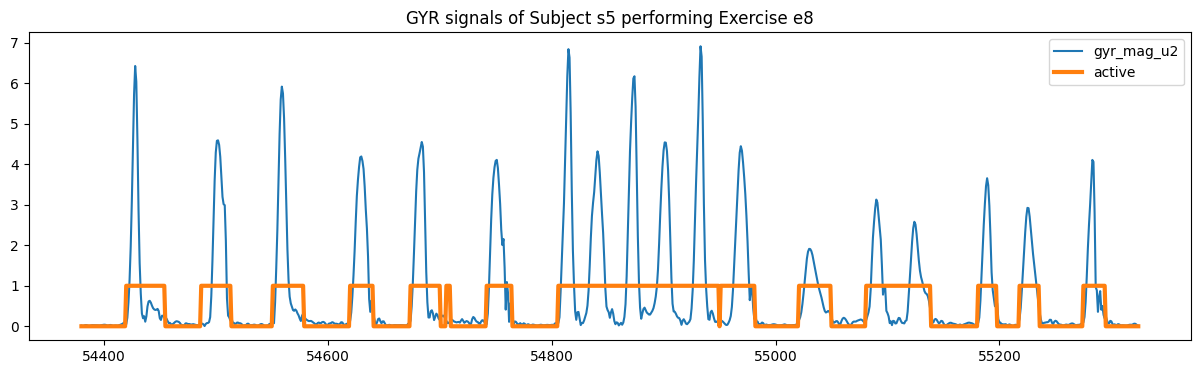

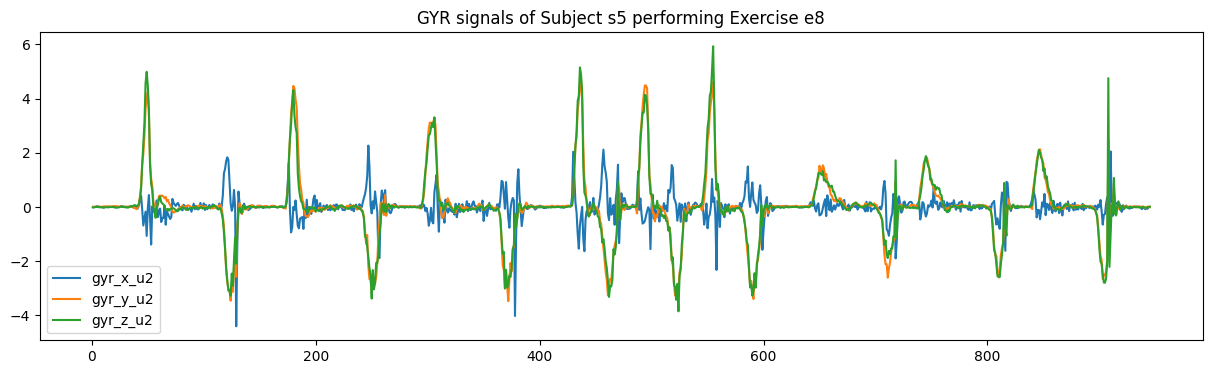

In [ ]:
subject = 's5'
exercise = 'e8'
unit = 2
mag_axis = ['mag'] # only for acc 
raw_axis = ['x', 'y', 'z']

plot_df2 = load_and_merge_sensors(templates, subject, exercise)

# Extract a single subject/exercise
plot_df = all_results[
    (all_results['subject'] == subject) &
    (all_results['exercise'] == exercise)
]

plot_subject_exercise({'merged_df': plot_df, 'subject':subject,'exercise':exercise}, axis=mag_axis, sensor_prefix='gyr', unit=unit)

plot_subject_exercise({'merged_df': plot_df2, 'subject':subject,'exercise':exercise}, axis=raw_axis, sensor_prefix='gyr', unit=unit, show_active=False, show_execution=False)

In [ ]:
import matplotlib.pyplot as plt

def plot_subject_reps(entry, full_reps, sensor_prefix='acc', axis=['x', 'y', 'z'], unit=1, show_active=True, show_execution=True):
    """
    Plot sensor data and overlay rep windows for a subject/exercise, 
    clipped to the DataFrame's timestep range.

    Parameters
    ----------
    entry : dict
        One element from all_data or all_tests containing:
        'merged_df', 'subject', 'exercise', ...
    full_reps : list of tuples
        List of (start, end) indices representing full rep windows.
    sensor_prefix : str
        Sensor to plot (default 'acc'). Can be 'gyr', 'mag', etc.
    axis : list
        List of axes to plot, e.g., ['x','y','z'].
    unit : int
        Unit number to plot (default 1)
    show_active : bool
        Whether to plot the 'active' column
    show_execution : bool
        Whether to plot the 'execution type' column
    """
    df = entry['merged_df']
    subject = entry['subject']
    exercise = entry['exercise']

    plt.figure(figsize=(15, 4))

    # Plot sensor channels
    for ax in axis:
        col = f"{sensor_prefix}_{ax}_u{unit}"
        if col in df.columns:
            plt.plot(df[col], label=col)

    # Optional: plot 'active'
    if show_active and 'active' in df.columns:
        plt.plot(df['active'], label='active', linewidth=2, alpha=0.7)
    
    # Optional: plot 'execution type'
    if show_execution and 'execution type' in df.columns:
        plt.plot(df['execution type'], label='execution type', linestyle='--', alpha=0.7)

    # Get current dataframe index range
    t_start = df.index.min()
    t_end = df.index.max()

    # Overlay full rep windows (clipped to df range)
    for start, end in full_reps:
        if end >= t_start and start <= t_end:
            plot_start = max(start, t_start)
            plot_end = min(end, t_end)
            plt.axvspan(plot_start, plot_end, color='red', alpha=0.3)

    plt.title(f"{sensor_prefix.upper()} signals of Subject {subject} performing Exercise {exercise}")
    plt.xlabel('Time Step')
    plt.ylabel('Signal')
    plt.legend()
    plt.show()


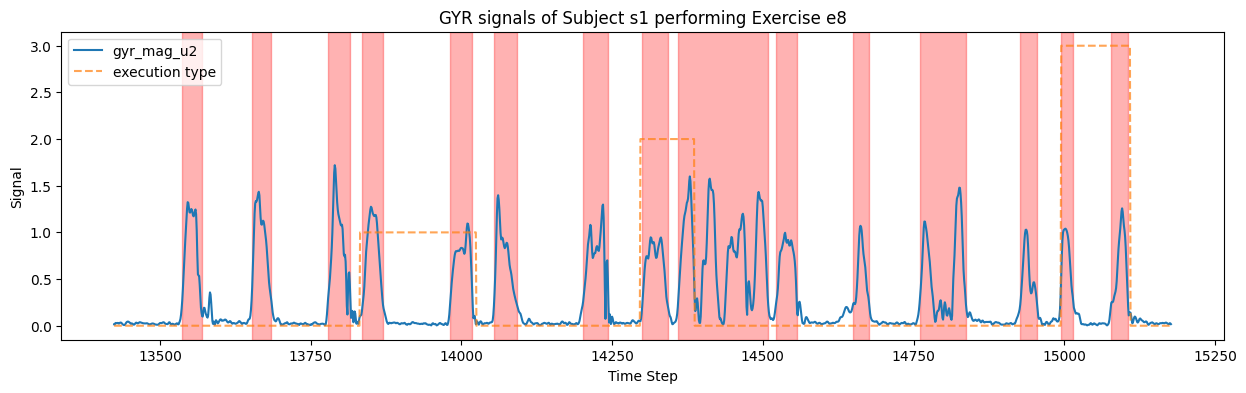

In [ ]:
full_reps = rep_bounds

# Suppose you already have:
# plot_df  -> your DataFrame
# subject  -> subject ID
# exercise -> exercise name
# full_reps -> list of tuples like [(76, 285), (318, 524), ...]

plot_subject_reps(
    entry={'merged_df': plot_df, 'subject': subject, 'exercise': exercise},
    full_reps=full_reps,          # <- here is your rep windows
    axis=mag_axis,                # e.g., ['x','y','z']
    sensor_prefix='gyr',          # e.g., 'acc', 'gyr', 'mag'
    unit=2,                    # e.g., 1
    show_active=True,
    show_execution=True
)


## Sample Training

### Activity Classifier

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all_active, test_size=0.2, random_state=42, stratify=y_all_active
)

NameError: name 'X_all' is not defined

In [ ]:
X_train.shape, y_train.shape

((1724, 50, 51), (1724,))

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

num_features = X_train.shape[2]
scalers = []

for i in range(num_features):
    scaler = StandardScaler()
    # Flatten samples x timesteps into one long vector for this feature
    X_train[:, :, i] = scaler.fit_transform(X_train[:, :, i].reshape(-1, 1)).reshape(X_train.shape[0], X_train.shape[1])
    X_val[:, :, i] = scaler.transform(X_val[:, :, i].reshape(-1, 1)).reshape(X_val.shape[0], X_val.shape[1])
    scalers.append(scaler)

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

num_classes = len(np.unique(y_activity))
window_size = X_train.shape[1]
num_features = X_train.shape[2]

model = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.LSTM(64, return_sequences=False),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

NameError: name 'y_activity' is not defined

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)   # e.g. [0,1]
cw = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight = dict(enumerate(cw))

model.fit(X_train, y_train, epochs=20, batch_size=64,
          validation_data=(X_val, y_val),
          class_weight=class_weight)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.3498 - loss: 0.6470 - val_accuracy: 0.6265 - val_loss: 0.6647
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6421 - loss: 0.5532 - val_accuracy: 0.8260 - val_loss: 0.5751
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8933 - loss: 0.4213 - val_accuracy: 0.9049 - val_loss: 0.4384
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9217 - loss: 0.3057 - val_accuracy: 0.9049 - val_loss: 0.3649
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9287 - loss: 0.2006 - val_accuracy: 0.9142 - val_loss: 0.2700
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9414 - loss: 0.1456 - val_accuracy: 0.9304 - val_loss: 0.2106
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9495 - loss: 0.1158 - val_accuracy: 0.9513 - val_loss: 0.1594
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9698 - loss: 0.0777 - val_accuracy: 0.9559 - v

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


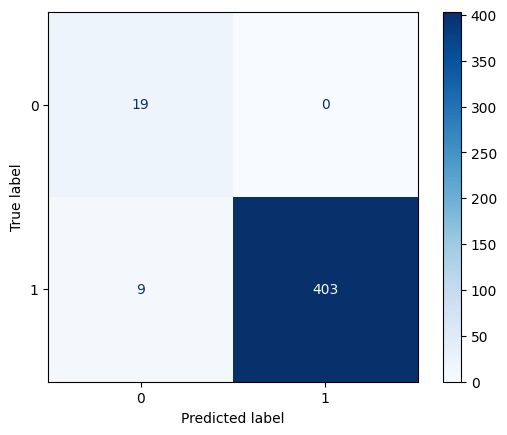

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = np.argmax(model.predict(X_val), axis=1)

cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.show()

### Exercise Classifier

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_seg, y_exercise, test_size=0.2, random_state=42, stratify=y_exercise
)

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1724, 50, 180), (1724,), (431, 50, 180), (431,))

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

num_features = X_train.shape[2]
scalers = []

for i in range(num_features):
    scaler = StandardScaler()
    # Flatten samples x timesteps into one long vector for this feature
    X_train[:, :, i] = scaler.fit_transform(X_train[:, :, i].reshape(-1, 1)).reshape(X_train.shape[0], X_train.shape[1])
    X_val[:, :, i] = scaler.transform(X_val[:, :, i].reshape(-1, 1)).reshape(X_val.shape[0], X_val.shape[1])
    scalers.append(scaler)


In [ ]:
from tensorflow.keras import layers, models

num_classes = len(np.unique(y_exercise))
window_size = X_train.shape[1]
num_features = X_train.shape[2]

model = models.Sequential([
    layers.Input(shape=(window_size, num_features)),
    layers.Bidirectional(layers.LSTM(128)),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_13                │ (None, 256)            │       316,416 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 318,472 (1.21 MB)

 Trainable params: 318,472 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(
    X_train,
    y_train,  # Convert one-hot to class indices
    epochs=10,
    validation_data=(X_val, y_val)
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9426 - loss: 0.2452 - val_accuracy: 0.9954 - val_loss: 0.0166
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9977 - loss: 0.0140 - val_accuracy: 1.0000 - val_loss: 0.0065
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9977 - loss: 0.0089 - val_accuracy: 1.0000 - val_loss: 0.0073
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9971 - loss: 0.0091 - val_accuracy: 1.0000 - val_loss: 0.0050
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9948 - loss: 0.0143 - val_accuracy: 1.0000 - val_loss: 0.0040
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9977 - loss: 0.0068 - val_accuracy: 1.0000 - v

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


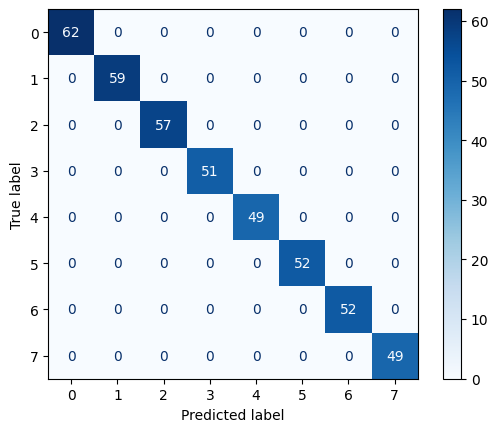

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = np.argmax(model.predict(X_val), axis=1)

cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.show()

In [ ]:
test_dfs

array([[0.008569258382720907, -0.0030380574937521315,
        0.0002378392119200082, ..., -1.961089211871579e-05, 's1', 'e1'],
       [0.005601743385390416, 0.009969512908649643, 0.011859418088261965,
        ..., 0.00014590757377114043, 's1', 'e1'],
       [0.004978492609254668, 0.016611512374203833, 0.009740225275236523,
        ..., 4.500925055298497e-05, 's1', 'e1'],
       ...,
       [-0.017965662392538877, 0.011059689728692331,
        -0.0014136966218730015, ..., -0.0015718344922227717, 's5', 'e8'],
       [-0.01404308275201831, 0.009457692544242354,
        0.0001493526596608903, ..., -0.001231027860563367, 's5', 'e8'],
       [-0.0017594616669490974, 0.007885742682947457,
        0.013003130554945824, ..., -0.0005759018515799218, 's5', 'e8']],
      shape=(220278, 47), dtype=object)

In [80]:
test_dfs = []
for subject in tests['subject'].unique():
    for exercise in tests['exercise'].unique():
        df = load_and_merge_sensors(tests, subject, exercise)
        test_filter = preprocess_sensor_data(df)
        test_dfs.append(test_filter)

test_dfs = pd.concat(test_dfs)

sensor_cols = [col for col in test_dfs.columns if any(sensor in col for sensor in ['acc_', 'gyr_', 'mag_'])]

test_segments_list = []
y_test_segments_list = []

label_map = {
    'e1': 1,
    'e2': 2,
    'e3': 3,
    'e4': 4,
    'e5': 5,
    'e6': 6,
    'e7': 7,
    'e8': 8
}

test_dfs['exercise'] = test_dfs['exercise'].map(label_map)

test_segments_list = []
y_test_segments_list = []
test_subject_windows_list = []

for (subject, exercise), group in test_dfs.groupby(['subject', 'exercise']):
    X = group[sensor_cols].values
    y_labels = group['exercise'].values  # numeric labels now

    X_windows, y_windows = segment_series(X, window_size=50, stride=25, y_labels=y_labels)
    test_segments_list.append(X_windows)
    y_test_segments_list.append(y_windows)
    
    # Keep track of subject for each window
    test_subject_windows_list.append(np.array([subject]*len(X_windows)))

# Combine all
test_segments = np.concatenate(X_segments_list, axis=0)
y_test_segments = np.concatenate(y_segments_list, axis=0)
test_subject_windows = np.concatenate(test_subject_windows_list, axis=0)  # NEW

## Data Export

Run everything in the ipynb and finish here

In [81]:
import pickle

train_dict = {
    'X_seg': X_windows_scaled,
    'y_exercise': y_segments,
    'subject_windows':subject_windows
}

test_dict = {
    'X_test': test_segments,
    'y_test_exercise': y_test_segments,
    'subject_test_windows': test_subject_windows
}

with open('../data/training.pkl', 'wb') as f:
    pickle.dump(train_dict, f)
    
with open('../data/test.pkl', 'wb') as f:
    pickle.dump(test_dict, f)